# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6156247714885117 -2.4988433310700557
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [36]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:11.0000 rate:0.0220 gloss:0.0870 dloss:1.4328 dlossR:0.7418 dlossQ:0.6909
Episode:1 meanR:9.5000 rate:0.0160 gloss:0.0259 dloss:1.3957 dlossR:0.7027 dlossQ:0.6930
Episode:2 meanR:9.6667 rate:0.0200 gloss:0.0099 dloss:1.3837 dlossR:0.6905 dlossQ:0.6932
Episode:3 meanR:9.7500 rate:0.0200 gloss:-0.0116 dloss:1.3665 dlossR:0.6734 dlossQ:0.6931
Episode:4 meanR:9.6000 rate:0.0180 gloss:-0.0454 dloss:1.3386 dlossR:0.6464 dlossQ:0.6922
Episode:5 meanR:9.6667 rate:0.0200 gloss:-0.0617 dloss:1.3212 dlossR:0.6302 dlossQ:0.6910
Episode:6 meanR:9.5714 rate:0.0180 gloss:-0.0939 dloss:1.2974 dlossR:0.6087 dlossQ:0.6887
Episode:7 meanR:9.5000 rate:0.0180 gloss:-0.1232 dloss:1.2762 dlossR:0.5902 dlossQ:0.6861
Episode:8 meanR:9.4444 rate:0.0180 gloss:-0.1694 dloss:1.2444 dlossR:0.5632 dlossQ:0.6812
Episode:9 meanR:9.4000 rate:0.0180 gloss:-0.2023 dloss:1.2265 dlossR:0.5487 dlossQ:0.6778
Episode:10 meanR:9.4545 rate:0.0200 gloss:-0.2526 dloss:1.1969 dlossR:0.5256 dlossQ:0.6713
Episode:11 

Episode:94 meanR:23.4526 rate:0.0980 gloss:-2.0368 dloss:0.5454 dlossR:0.3466 dlossQ:0.1987
Episode:95 meanR:23.7188 rate:0.0980 gloss:-2.0500 dloss:0.5437 dlossR:0.3484 dlossQ:0.1953
Episode:96 meanR:24.1237 rate:0.1260 gloss:-2.0089 dloss:0.6361 dlossR:0.4325 dlossQ:0.2036
Episode:97 meanR:24.4694 rate:0.1160 gloss:-2.0265 dloss:0.6031 dlossR:0.4031 dlossQ:0.1999
Episode:98 meanR:24.4141 rate:0.0380 gloss:-2.1106 dloss:0.3469 dlossR:0.1624 dlossQ:0.1845
Episode:99 meanR:24.3500 rate:0.0360 gloss:-2.1684 dloss:0.3292 dlossR:0.1555 dlossQ:0.1737
Episode:100 meanR:24.4100 rate:0.0340 gloss:-2.2123 dloss:0.3155 dlossR:0.1492 dlossQ:0.1664
Episode:101 meanR:24.4200 rate:0.0180 gloss:-2.4055 dloss:0.2330 dlossR:0.0951 dlossQ:0.1379
Episode:102 meanR:24.4900 rate:0.0340 gloss:-2.1171 dloss:0.3344 dlossR:0.1502 dlossQ:0.1841
Episode:103 meanR:24.6200 rate:0.0460 gloss:-2.0497 dloss:0.3828 dlossR:0.1869 dlossQ:0.1959
Episode:104 meanR:24.8600 rate:0.0660 gloss:-2.1190 dloss:0.4412 dlossR:0.25

Episode:185 meanR:46.0500 rate:0.2480 gloss:-1.2043 dloss:1.0510 dlossR:0.6251 dlossQ:0.4259
Episode:186 meanR:46.8500 rate:0.1800 gloss:-1.2438 dloss:0.8988 dlossR:0.4877 dlossQ:0.4111
Episode:187 meanR:47.6900 rate:0.1900 gloss:-1.2278 dloss:0.9234 dlossR:0.5068 dlossQ:0.4166
Episode:188 meanR:48.0800 rate:0.1020 gloss:-1.2752 dloss:0.7328 dlossR:0.3328 dlossQ:0.4000
Episode:189 meanR:48.4500 rate:0.0960 gloss:-1.2188 dloss:0.7414 dlossR:0.3235 dlossQ:0.4179
Episode:190 meanR:48.8300 rate:0.1020 gloss:-1.1783 dloss:0.7678 dlossR:0.3367 dlossQ:0.4311
Episode:191 meanR:49.0300 rate:0.0680 gloss:-1.2449 dloss:0.6805 dlossR:0.2711 dlossQ:0.4095
Episode:192 meanR:49.1900 rate:0.0700 gloss:-1.1762 dloss:0.7120 dlossR:0.2807 dlossQ:0.4312
Episode:193 meanR:49.0700 rate:0.0620 gloss:-1.2192 dloss:0.6806 dlossR:0.2627 dlossQ:0.4178
Episode:194 meanR:48.8200 rate:0.0480 gloss:-1.1770 dloss:0.6745 dlossR:0.2436 dlossQ:0.4309
Episode:195 meanR:48.7100 rate:0.0760 gloss:-1.2075 dloss:0.7097 dloss

Episode:275 meanR:37.5500 rate:0.1280 gloss:-1.7048 dloss:0.6818 dlossR:0.4059 dlossQ:0.2759
Episode:276 meanR:37.7000 rate:0.0740 gloss:-1.7422 dloss:0.5312 dlossR:0.2647 dlossQ:0.2664
Episode:277 meanR:37.7700 rate:0.1020 gloss:-1.7290 dloss:0.6081 dlossR:0.3383 dlossQ:0.2698
Episode:278 meanR:37.9000 rate:0.0760 gloss:-1.7494 dloss:0.5352 dlossR:0.2702 dlossQ:0.2650
Episode:279 meanR:37.9200 rate:0.0560 gloss:-1.7362 dloss:0.4856 dlossR:0.2177 dlossQ:0.2679
Episode:280 meanR:38.1300 rate:0.0760 gloss:-1.7345 dloss:0.5386 dlossR:0.2698 dlossQ:0.2688
Episode:281 meanR:37.8500 rate:0.0580 gloss:-1.7791 dloss:0.4811 dlossR:0.2228 dlossQ:0.2584
Episode:282 meanR:36.9400 rate:0.0560 gloss:-1.7828 dloss:0.4753 dlossR:0.2176 dlossQ:0.2578
Episode:283 meanR:36.6800 rate:0.0460 gloss:-1.8489 dloss:0.4335 dlossR:0.1903 dlossQ:0.2432
Episode:284 meanR:35.3400 rate:0.0400 gloss:-1.8559 dloss:0.4166 dlossR:0.1744 dlossQ:0.2422
Episode:285 meanR:34.2800 rate:0.0360 gloss:-1.9390 dloss:0.3875 dloss

Episode:365 meanR:59.0400 rate:0.0760 gloss:-0.8233 dloss:0.8887 dlossR:0.3438 dlossQ:0.5449
Episode:366 meanR:59.1600 rate:0.0660 gloss:-0.8362 dloss:0.8708 dlossR:0.3300 dlossQ:0.5408
Episode:367 meanR:59.3800 rate:0.0820 gloss:-0.8431 dloss:0.8864 dlossR:0.3472 dlossQ:0.5392
Episode:368 meanR:59.6500 rate:0.0780 gloss:-0.8520 dloss:0.8767 dlossR:0.3408 dlossQ:0.5358
Episode:369 meanR:59.7600 rate:0.0680 gloss:-0.8767 dloss:0.8527 dlossR:0.3241 dlossQ:0.5286
Episode:370 meanR:59.9500 rate:0.0820 gloss:-0.8858 dloss:0.8658 dlossR:0.3397 dlossQ:0.5261
Episode:371 meanR:60.1200 rate:0.0760 gloss:-0.8905 dloss:0.8555 dlossR:0.3314 dlossQ:0.5242
Episode:372 meanR:60.0800 rate:0.0600 gloss:-0.9311 dloss:0.8151 dlossR:0.3039 dlossQ:0.5113
Episode:373 meanR:59.7000 rate:0.0900 gloss:-0.9097 dloss:0.8641 dlossR:0.3461 dlossQ:0.5181
Episode:374 meanR:59.1400 rate:0.0820 gloss:-0.9560 dloss:0.8327 dlossR:0.3289 dlossQ:0.5038
Episode:375 meanR:58.9000 rate:0.0800 gloss:-0.9616 dloss:0.8270 dloss

Episode:457 meanR:76.0800 rate:0.1300 gloss:-0.6693 dloss:1.0229 dlossR:0.4324 dlossQ:0.5905
Episode:458 meanR:75.8700 rate:0.1740 gloss:-0.6235 dloss:1.0868 dlossR:0.4824 dlossQ:0.6044
Episode:459 meanR:76.0400 rate:0.1080 gloss:-0.6954 dloss:0.9879 dlossR:0.4044 dlossQ:0.5834
Episode:460 meanR:76.2300 rate:0.1040 gloss:-0.7199 dloss:0.9721 dlossR:0.3961 dlossQ:0.5760
Episode:461 meanR:75.8100 rate:0.0260 gloss:-0.8072 dloss:0.8500 dlossR:0.3005 dlossQ:0.5495
Episode:462 meanR:75.6600 rate:0.0260 gloss:-0.8682 dloss:0.8155 dlossR:0.2849 dlossQ:0.5306
Episode:463 meanR:75.4400 rate:0.0300 gloss:-0.8505 dloss:0.8284 dlossR:0.2924 dlossQ:0.5360
Episode:464 meanR:75.0700 rate:0.0280 gloss:-0.9029 dloss:0.7975 dlossR:0.2780 dlossQ:0.5195
Episode:465 meanR:74.8000 rate:0.0220 gloss:-0.9737 dloss:0.7534 dlossR:0.2564 dlossQ:0.4971
Episode:466 meanR:74.6000 rate:0.0260 gloss:-0.9839 dloss:0.7522 dlossR:0.2580 dlossQ:0.4942
Episode:467 meanR:74.3400 rate:0.0300 gloss:-1.0203 dloss:0.7372 dloss

Episode:551 meanR:44.7800 rate:0.3880 gloss:-1.3692 dloss:1.4044 dlossR:1.0198 dlossQ:0.3846
Episode:552 meanR:44.6700 rate:0.1260 gloss:-1.8396 dloss:0.6726 dlossR:0.4187 dlossQ:0.2539
Episode:553 meanR:44.2700 rate:0.0820 gloss:-1.6402 dloss:0.5835 dlossR:0.2863 dlossQ:0.2972
Episode:554 meanR:43.2900 rate:0.0400 gloss:-1.8941 dloss:0.4074 dlossR:0.1732 dlossQ:0.2341
Episode:555 meanR:42.7700 rate:0.0360 gloss:-1.9033 dloss:0.3943 dlossR:0.1622 dlossQ:0.2321
Episode:556 meanR:42.2700 rate:0.0300 gloss:-2.0705 dloss:0.3415 dlossR:0.1426 dlossQ:0.1988
Episode:557 meanR:41.7200 rate:0.0200 gloss:-2.1711 dloss:0.2921 dlossR:0.1115 dlossQ:0.1806
Episode:558 meanR:41.0200 rate:0.0340 gloss:-1.9910 dloss:0.3683 dlossR:0.1547 dlossQ:0.2136
Episode:559 meanR:40.6700 rate:0.0380 gloss:-1.8366 dloss:0.4173 dlossR:0.1697 dlossQ:0.2476
Episode:560 meanR:40.3800 rate:0.0460 gloss:-1.7464 dloss:0.4616 dlossR:0.1929 dlossQ:0.2687
Episode:561 meanR:40.5500 rate:0.0600 gloss:-1.7202 dloss:0.5044 dloss

Episode:641 meanR:102.9700 rate:0.1920 gloss:-0.9364 dloss:1.0275 dlossR:0.5146 dlossQ:0.5129
Episode:642 meanR:103.5700 rate:0.1820 gloss:-0.9638 dloss:1.0052 dlossR:0.5024 dlossQ:0.5028
Episode:643 meanR:104.1700 rate:0.1780 gloss:-1.0402 dloss:0.9751 dlossR:0.4934 dlossQ:0.4817
Episode:644 meanR:103.9700 rate:0.0260 gloss:-0.7447 dloss:0.8931 dlossR:0.3256 dlossQ:0.5675
Episode:645 meanR:103.9100 rate:0.0220 gloss:-0.8295 dloss:0.8376 dlossR:0.2952 dlossQ:0.5424
Episode:646 meanR:103.8500 rate:0.0300 gloss:-0.7424 dloss:0.8968 dlossR:0.3276 dlossQ:0.5692
Episode:647 meanR:104.6900 rate:0.2240 gloss:-1.0319 dloss:1.0431 dlossR:0.5614 dlossQ:0.4817
Episode:648 meanR:105.5700 rate:0.2220 gloss:-1.0739 dloss:1.0398 dlossR:0.5679 dlossQ:0.4719
Episode:649 meanR:106.6900 rate:0.2460 gloss:-0.9966 dloss:1.0912 dlossR:0.5975 dlossQ:0.4937
Episode:650 meanR:107.9400 rate:0.2800 gloss:-0.9309 dloss:1.1606 dlossR:0.6459 dlossQ:0.5147
Episode:651 meanR:107.4000 rate:0.2800 gloss:-0.9642 dloss:1

Episode:732 meanR:71.8300 rate:0.2320 gloss:-1.0104 dloss:1.0699 dlossR:0.5753 dlossQ:0.4947
Episode:733 meanR:74.9400 rate:0.7860 gloss:-0.2649 dloss:1.9445 dlossR:1.2001 dlossQ:0.7444
Episode:734 meanR:75.6900 rate:0.2360 gloss:-0.6992 dloss:1.1400 dlossR:0.5527 dlossQ:0.5873
Episode:735 meanR:76.3900 rate:0.2200 gloss:-0.6522 dloss:1.1322 dlossR:0.5330 dlossQ:0.5992
Episode:736 meanR:76.3300 rate:0.0680 gloss:-1.0450 dloss:0.7926 dlossR:0.3123 dlossQ:0.4804
Episode:737 meanR:77.3100 rate:0.2740 gloss:-0.6372 dloss:1.2041 dlossR:0.5982 dlossQ:0.6059
Episode:738 meanR:78.0400 rate:0.2160 gloss:-0.5518 dloss:1.1579 dlossR:0.5325 dlossQ:0.6255
Episode:739 meanR:78.6300 rate:0.2480 gloss:-0.5582 dloss:1.1900 dlossR:0.5651 dlossQ:0.6249
Episode:740 meanR:78.6900 rate:0.2220 gloss:-0.4960 dloss:1.1804 dlossR:0.5422 dlossQ:0.6382
Episode:741 meanR:79.2900 rate:0.3120 gloss:-0.5351 dloss:1.2689 dlossR:0.6359 dlossQ:0.6329
Episode:742 meanR:79.8000 rate:0.2840 gloss:-0.5016 dloss:1.2422 dloss

Episode:820 meanR:105.4100 rate:0.2960 gloss:-0.2372 dloss:1.3059 dlossR:0.6265 dlossQ:0.6795
Episode:821 meanR:104.3400 rate:0.0220 gloss:-1.5778 dloss:0.5267 dlossR:0.1936 dlossQ:0.3331
Episode:822 meanR:104.6100 rate:0.2700 gloss:-0.1297 dloss:1.3119 dlossR:0.6212 dlossQ:0.6907
Episode:823 meanR:108.4700 rate:1.0000 gloss:0.2619 dloss:1.8576 dlossR:1.0584 dlossQ:0.7992
Episode:824 meanR:108.4200 rate:0.0800 gloss:-0.8693 dloss:0.8739 dlossR:0.3442 dlossQ:0.5297
Episode:825 meanR:107.7500 rate:0.0800 gloss:-0.6929 dloss:0.9656 dlossR:0.3840 dlossQ:0.5816
Episode:826 meanR:107.6200 rate:0.0500 gloss:-0.8001 dloss:0.8779 dlossR:0.3254 dlossQ:0.5526
Episode:827 meanR:107.7100 rate:0.0400 gloss:-0.8148 dloss:0.8606 dlossR:0.3126 dlossQ:0.5481
Episode:828 meanR:106.2600 rate:0.0440 gloss:-0.6693 dloss:0.9499 dlossR:0.3591 dlossQ:0.5908
Episode:829 meanR:105.5100 rate:0.0220 gloss:-1.0251 dloss:0.7321 dlossR:0.2502 dlossQ:0.4818
Episode:830 meanR:105.5700 rate:0.0320 gloss:-0.7932 dloss:0.

Episode:909 meanR:82.6300 rate:0.3920 gloss:-0.1513 dloss:1.3815 dlossR:0.6979 dlossQ:0.6836
Episode:910 meanR:82.6100 rate:0.4580 gloss:-0.1462 dloss:1.4351 dlossR:0.7505 dlossQ:0.6846
Episode:911 meanR:84.2100 rate:0.5020 gloss:-0.1021 dloss:1.4689 dlossR:0.7744 dlossQ:0.6946
Episode:912 meanR:86.1900 rate:0.5220 gloss:-0.1338 dloss:1.4946 dlossR:0.8012 dlossQ:0.6934
Episode:913 meanR:87.4900 rate:0.4520 gloss:-0.0841 dloss:1.4249 dlossR:0.7232 dlossQ:0.7017
Episode:914 meanR:89.5300 rate:0.5640 gloss:0.0293 dloss:1.4943 dlossR:0.7835 dlossQ:0.7109
Episode:915 meanR:92.1700 rate:0.5960 gloss:-0.0401 dloss:1.5463 dlossR:0.8353 dlossQ:0.7109
Episode:916 meanR:94.5500 rate:0.6300 gloss:-0.0314 dloss:1.5796 dlossR:0.8668 dlossQ:0.7129
Episode:917 meanR:96.6700 rate:0.4980 gloss:0.0210 dloss:1.4448 dlossR:0.7356 dlossQ:0.7092
Episode:918 meanR:94.8400 rate:0.6340 gloss:-0.0191 dloss:1.5791 dlossR:0.8650 dlossQ:0.7141
Episode:919 meanR:96.8800 rate:0.7160 gloss:0.0519 dloss:1.6390 dlossR:0

Episode:999 meanR:193.9300 rate:0.4660 gloss:0.0523 dloss:1.4186 dlossR:0.7102 dlossQ:0.7084
Episode:1000 meanR:194.1800 rate:0.1960 gloss:-0.1532 dloss:1.2823 dlossR:0.6140 dlossQ:0.6683
Episode:1001 meanR:194.3900 rate:0.2060 gloss:-0.3151 dloss:1.2274 dlossR:0.5621 dlossQ:0.6653
Episode:1002 meanR:197.2100 rate:0.7280 gloss:0.4132 dloss:1.4407 dlossR:0.7310 dlossQ:0.7098
Episode:1003 meanR:198.0500 rate:0.2800 gloss:-0.0129 dloss:1.3428 dlossR:0.6425 dlossQ:0.7003
Episode:1004 meanR:197.8100 rate:0.2320 gloss:0.2045 dloss:1.4002 dlossR:0.7124 dlossQ:0.6878
Episode:1005 meanR:198.8300 rate:0.5040 gloss:0.2739 dloss:1.4018 dlossR:0.7022 dlossQ:0.6996
Episode:1006 meanR:199.5000 rate:0.4000 gloss:0.2461 dloss:1.3887 dlossR:0.7003 dlossQ:0.6884
Episode:1007 meanR:199.7800 rate:0.3080 gloss:-0.0107 dloss:1.3501 dlossR:0.6540 dlossQ:0.6961
Episode:1008 meanR:199.7100 rate:0.3340 gloss:0.0911 dloss:1.3706 dlossR:0.6677 dlossQ:0.7029
Episode:1009 meanR:199.5100 rate:0.3520 gloss:0.0984 dlos

Episode:1086 meanR:113.3500 rate:0.1880 gloss:-1.0447 dloss:0.9658 dlossR:0.4925 dlossQ:0.4733
Episode:1087 meanR:111.1900 rate:0.2560 gloss:-0.8707 dloss:1.1225 dlossR:0.5902 dlossQ:0.5323
Episode:1088 meanR:106.3000 rate:0.0220 gloss:-2.1430 dloss:0.3423 dlossR:0.1384 dlossQ:0.2039
Episode:1089 meanR:109.1500 rate:1.0000 gloss:-0.0477 dloss:2.1870 dlossR:1.3758 dlossQ:0.8112
Episode:1090 meanR:107.2300 rate:0.0720 gloss:-1.2507 dloss:0.7520 dlossR:0.3189 dlossQ:0.4331
Episode:1091 meanR:105.4800 rate:0.0360 gloss:-1.1724 dloss:0.6691 dlossR:0.2320 dlossQ:0.4371
Episode:1092 meanR:102.8500 rate:0.0240 gloss:-1.2917 dloss:0.5978 dlossR:0.1982 dlossQ:0.3996
Episode:1093 meanR:101.5200 rate:0.0260 gloss:-1.3823 dloss:0.5587 dlossR:0.1875 dlossQ:0.3712
Episode:1094 meanR:99.6200 rate:0.0200 gloss:-1.3361 dloss:0.5733 dlossR:0.1879 dlossQ:0.3854
Episode:1095 meanR:97.4700 rate:0.0260 gloss:-1.2406 dloss:0.6257 dlossR:0.2093 dlossQ:0.4164
Episode:1096 meanR:96.5300 rate:0.0620 gloss:-1.0140

Episode:1177 meanR:53.0700 rate:0.0280 gloss:-1.6298 dloss:0.4620 dlossR:0.1612 dlossQ:0.3007
Episode:1178 meanR:53.1100 rate:0.0420 gloss:-1.7036 dloss:0.4701 dlossR:0.1880 dlossQ:0.2821
Episode:1179 meanR:53.1700 rate:0.0460 gloss:-1.6615 dloss:0.4919 dlossR:0.1993 dlossQ:0.2926
Episode:1180 meanR:53.1900 rate:0.0320 gloss:-1.5850 dloss:0.4890 dlossR:0.1749 dlossQ:0.3141
Episode:1181 meanR:53.2100 rate:0.0380 gloss:-1.6359 dloss:0.4847 dlossR:0.1840 dlossQ:0.3007
Episode:1182 meanR:53.2900 rate:0.0420 gloss:-1.7478 dloss:0.4556 dlossR:0.1853 dlossQ:0.2703
Episode:1183 meanR:53.2700 rate:0.0440 gloss:-1.7036 dloss:0.4778 dlossR:0.1941 dlossQ:0.2837
Episode:1184 meanR:53.2600 rate:0.0440 gloss:-1.7904 dloss:0.4510 dlossR:0.1898 dlossQ:0.2612
Episode:1185 meanR:53.2900 rate:0.0380 gloss:-1.8660 dloss:0.4134 dlossR:0.1709 dlossQ:0.2424
Episode:1186 meanR:52.5700 rate:0.0440 gloss:-1.8697 dloss:0.4266 dlossR:0.1859 dlossQ:0.2407
Episode:1187 meanR:51.4900 rate:0.0400 gloss:-1.8419 dloss:0

Episode:1265 meanR:42.9500 rate:0.2700 gloss:-1.2231 dloss:1.1010 dlossR:0.6777 dlossQ:0.4233
Episode:1266 meanR:44.9000 rate:0.4420 gloss:-0.5720 dloss:1.4544 dlossR:0.8389 dlossQ:0.6155
Episode:1267 meanR:45.5400 rate:0.1700 gloss:-0.9236 dloss:0.9880 dlossR:0.4725 dlossQ:0.5155
Episode:1268 meanR:45.7700 rate:0.1060 gloss:-1.3128 dloss:0.7434 dlossR:0.3465 dlossQ:0.3969
Episode:1269 meanR:45.8100 rate:0.0600 gloss:-1.5291 dloss:0.5737 dlossR:0.2405 dlossQ:0.3332
Episode:1270 meanR:45.1400 rate:0.0460 gloss:-1.6461 dloss:0.5099 dlossR:0.2063 dlossQ:0.3037
Episode:1271 meanR:44.4000 rate:0.0240 gloss:-1.9803 dloss:0.3619 dlossR:0.1376 dlossQ:0.2244
Episode:1272 meanR:44.0300 rate:0.0220 gloss:-2.1840 dloss:0.3140 dlossR:0.1265 dlossQ:0.1875
Episode:1273 meanR:43.8400 rate:0.0180 gloss:-2.2580 dloss:0.2979 dlossR:0.1172 dlossQ:0.1807
Episode:1274 meanR:43.6900 rate:0.0220 gloss:-2.1227 dloss:0.3333 dlossR:0.1322 dlossQ:0.2011
Episode:1275 meanR:44.1400 rate:0.1500 gloss:-0.9933 dloss:0

Episode:1353 meanR:155.4200 rate:0.7860 gloss:0.8660 dloss:1.1784 dlossR:0.5891 dlossQ:0.5893
Episode:1354 meanR:156.1600 rate:0.3840 gloss:1.1613 dloss:1.5059 dlossR:1.0566 dlossQ:0.4493
Episode:1355 meanR:160.2200 rate:1.0000 gloss:1.0997 dloss:0.9828 dlossR:0.4424 dlossQ:0.5403
Episode:1356 meanR:164.7900 rate:1.0000 gloss:1.0872 dloss:0.9924 dlossR:0.4473 dlossQ:0.5451
Episode:1357 meanR:167.5500 rate:0.5740 gloss:1.2421 dloss:1.2329 dlossR:0.7951 dlossQ:0.4378
Episode:1358 meanR:170.1400 rate:0.7000 gloss:1.2878 dloss:1.0660 dlossR:0.6328 dlossQ:0.4332
Episode:1359 meanR:170.5400 rate:0.3260 gloss:1.1968 dloss:1.6174 dlossR:1.1827 dlossQ:0.4347
Episode:1360 meanR:175.2600 rate:1.0000 gloss:1.3118 dloss:0.7983 dlossR:0.3401 dlossQ:0.4582
Episode:1361 meanR:177.0100 rate:0.3740 gloss:1.1233 dloss:1.5046 dlossR:1.0454 dlossQ:0.4592
Episode:1362 meanR:180.3700 rate:0.6920 gloss:1.2342 dloss:1.0784 dlossR:0.6309 dlossQ:0.4475
Episode:1363 meanR:181.8400 rate:0.3620 gloss:1.0619 dloss:1

Episode:1441 meanR:250.8000 rate:0.3980 gloss:0.2578 dloss:1.3866 dlossR:0.6943 dlossQ:0.6923
Episode:1442 meanR:249.0300 rate:0.2080 gloss:0.1105 dloss:1.3789 dlossR:0.6848 dlossQ:0.6941
Episode:1443 meanR:247.4000 rate:0.3520 gloss:0.2026 dloss:1.3845 dlossR:0.6889 dlossQ:0.6956
Episode:1444 meanR:246.9000 rate:0.3260 gloss:0.1680 dloss:1.3809 dlossR:0.6836 dlossQ:0.6973
Episode:1445 meanR:245.7100 rate:0.2440 gloss:0.1164 dloss:1.3753 dlossR:0.6794 dlossQ:0.6959
Episode:1446 meanR:244.1900 rate:0.3120 gloss:0.1323 dloss:1.3754 dlossR:0.6758 dlossQ:0.6995
Episode:1447 meanR:243.3700 rate:0.3060 gloss:0.1332 dloss:1.3755 dlossR:0.6765 dlossQ:0.6990
Episode:1448 meanR:243.1700 rate:0.4780 gloss:-0.0278 dloss:1.4333 dlossR:0.7462 dlossQ:0.6870
Episode:1449 meanR:242.1000 rate:0.2800 gloss:0.1160 dloss:1.3724 dlossR:0.6740 dlossQ:0.6984
Episode:1450 meanR:241.3000 rate:0.3660 gloss:0.1282 dloss:1.3799 dlossR:0.6753 dlossQ:0.7046
Episode:1451 meanR:239.8200 rate:0.2600 gloss:-0.4925 dloss

Episode:1528 meanR:150.0400 rate:0.1420 gloss:-0.4485 dloss:1.0901 dlossR:0.4703 dlossQ:0.6198
Episode:1529 meanR:149.5000 rate:0.1160 gloss:-0.5291 dloss:1.0315 dlossR:0.4315 dlossQ:0.6000
Episode:1530 meanR:149.4100 rate:0.1640 gloss:-0.4729 dloss:1.1086 dlossR:0.4865 dlossQ:0.6221
Episode:1531 meanR:149.0500 rate:0.1460 gloss:-0.6095 dloss:1.0289 dlossR:0.4498 dlossQ:0.5791
Episode:1532 meanR:148.3600 rate:0.1160 gloss:-0.7372 dloss:0.9353 dlossR:0.3960 dlossQ:0.5393
Episode:1533 meanR:147.7900 rate:0.1360 gloss:-0.7376 dloss:0.9666 dlossR:0.4238 dlossQ:0.5427
Episode:1534 meanR:147.3500 rate:0.1340 gloss:-0.7875 dloss:0.9471 dlossR:0.4175 dlossQ:0.5296
Episode:1535 meanR:146.6500 rate:0.1460 gloss:-0.8166 dloss:0.9568 dlossR:0.4339 dlossQ:0.5229
Episode:1536 meanR:145.2400 rate:0.1480 gloss:-0.8269 dloss:0.9594 dlossR:0.4367 dlossQ:0.5227
Episode:1537 meanR:144.4800 rate:0.1280 gloss:-0.9321 dloss:0.8913 dlossR:0.4002 dlossQ:0.4912
Episode:1538 meanR:143.6800 rate:0.1100 gloss:-1.0

Episode:1622 meanR:45.3500 rate:0.1380 gloss:-1.0274 dloss:0.8868 dlossR:0.4051 dlossQ:0.4817
Episode:1623 meanR:45.3000 rate:0.1260 gloss:-0.9820 dloss:0.8845 dlossR:0.3890 dlossQ:0.4955
Episode:1624 meanR:44.9500 rate:0.0300 gloss:-1.2041 dloss:0.6399 dlossR:0.2147 dlossQ:0.4252
Episode:1625 meanR:44.6500 rate:0.0340 gloss:-1.1746 dloss:0.6603 dlossR:0.2258 dlossQ:0.4345
Episode:1626 meanR:44.2500 rate:0.0320 gloss:-1.2634 dloss:0.6143 dlossR:0.2085 dlossQ:0.4058
Episode:1627 meanR:43.4200 rate:0.0260 gloss:-1.3692 dloss:0.5591 dlossR:0.1860 dlossQ:0.3730
Episode:1628 meanR:42.9400 rate:0.0460 gloss:-1.1383 dloss:0.6963 dlossR:0.2502 dlossQ:0.4461
Episode:1629 meanR:42.6100 rate:0.0500 gloss:-1.1020 dloss:0.7181 dlossR:0.2606 dlossQ:0.4575
Episode:1630 meanR:42.3600 rate:0.1140 gloss:-1.0026 dloss:0.8600 dlossR:0.3707 dlossQ:0.4893
Episode:1631 meanR:42.0700 rate:0.0880 gloss:-1.0980 dloss:0.7879 dlossR:0.3267 dlossQ:0.4612
Episode:1632 meanR:42.4100 rate:0.1840 gloss:-1.0387 dloss:0

Episode:1710 meanR:48.8400 rate:0.1020 gloss:-1.3689 dloss:0.7119 dlossR:0.3357 dlossQ:0.3762
Episode:1711 meanR:49.8400 rate:0.6480 gloss:-0.9440 dloss:1.9812 dlossR:1.4424 dlossQ:0.5388
Episode:1712 meanR:48.6000 rate:0.2040 gloss:-1.2132 dloss:0.9637 dlossR:0.5378 dlossQ:0.4259
Episode:1713 meanR:47.4300 rate:0.0920 gloss:-1.3554 dloss:0.7032 dlossR:0.3200 dlossQ:0.3832
Episode:1714 meanR:48.1500 rate:0.1840 gloss:-1.2031 dloss:0.9267 dlossR:0.4974 dlossQ:0.4292
Episode:1715 meanR:48.4200 rate:0.0920 gloss:-1.3236 dloss:0.7128 dlossR:0.3204 dlossQ:0.3923
Episode:1716 meanR:48.6300 rate:0.0680 gloss:-1.3542 dloss:0.6592 dlossR:0.2743 dlossQ:0.3849
Episode:1717 meanR:48.8600 rate:0.0800 gloss:-1.2942 dloss:0.6993 dlossR:0.2986 dlossQ:0.4007
Episode:1718 meanR:48.9200 rate:0.0460 gloss:-1.3453 dloss:0.6043 dlossR:0.2226 dlossQ:0.3816
Episode:1719 meanR:48.9600 rate:0.0340 gloss:-1.4560 dloss:0.5340 dlossR:0.1872 dlossQ:0.3468
Episode:1720 meanR:48.9900 rate:0.0300 gloss:-1.5043 dloss:0

Episode:1799 meanR:49.1000 rate:0.1600 gloss:-1.2376 dloss:0.8603 dlossR:0.4464 dlossQ:0.4139
Episode:1800 meanR:48.7800 rate:0.2720 gloss:-1.0958 dloss:1.1166 dlossR:0.6535 dlossQ:0.4631
Episode:1801 meanR:50.1800 rate:0.4440 gloss:-0.9657 dloss:1.4852 dlossR:0.9706 dlossQ:0.5147
Episode:1802 meanR:50.2900 rate:0.4160 gloss:-1.0572 dloss:1.4320 dlossR:0.9488 dlossQ:0.4831
Episode:1803 meanR:51.8400 rate:0.4420 gloss:-1.0822 dloss:1.4985 dlossR:1.0220 dlossQ:0.4764
Episode:1804 meanR:52.7700 rate:0.2440 gloss:-1.1231 dloss:1.0566 dlossR:0.6027 dlossQ:0.4539
Episode:1805 meanR:53.7100 rate:0.2260 gloss:-1.2489 dloss:1.0002 dlossR:0.5869 dlossQ:0.4132
Episode:1806 meanR:54.0400 rate:0.1100 gloss:-1.3513 dloss:0.7314 dlossR:0.3507 dlossQ:0.3807
Episode:1807 meanR:54.2100 rate:0.0700 gloss:-1.3314 dloss:0.6594 dlossR:0.2712 dlossQ:0.3882
Episode:1808 meanR:54.2700 rate:0.0560 gloss:-1.3138 dloss:0.6376 dlossR:0.2450 dlossQ:0.3926
Episode:1809 meanR:54.3100 rate:0.0740 gloss:-1.2428 dloss:0

Episode:1890 meanR:78.3500 rate:0.0680 gloss:-0.9903 dloss:0.8031 dlossR:0.3079 dlossQ:0.4952
Episode:1891 meanR:78.4900 rate:0.0560 gloss:-1.0238 dloss:0.7669 dlossR:0.2834 dlossQ:0.4835
Episode:1892 meanR:78.6600 rate:0.0780 gloss:-0.9811 dloss:0.8191 dlossR:0.3214 dlossQ:0.4977
Episode:1893 meanR:78.7400 rate:0.0880 gloss:-0.9706 dloss:0.8416 dlossR:0.3404 dlossQ:0.5012
Episode:1894 meanR:79.0300 rate:0.1200 gloss:-0.8987 dloss:0.9137 dlossR:0.3909 dlossQ:0.5228
Episode:1895 meanR:79.3000 rate:0.1800 gloss:-0.7612 dloss:1.0451 dlossR:0.4795 dlossQ:0.5656
Episode:1896 meanR:79.8600 rate:0.2760 gloss:-0.6598 dloss:1.1988 dlossR:0.6020 dlossQ:0.5968
Episode:1897 meanR:80.8500 rate:0.2700 gloss:-0.6927 dloss:1.1835 dlossR:0.5931 dlossQ:0.5904
Episode:1898 meanR:85.4500 rate:1.0000 gloss:-0.2365 dloss:2.3792 dlossR:1.5849 dlossQ:0.7943
Episode:1899 meanR:85.9400 rate:0.2580 gloss:-0.8216 dloss:1.1450 dlossR:0.5921 dlossQ:0.5530
Episode:1900 meanR:86.1000 rate:0.3040 gloss:-0.7615 dloss:1

Episode:1978 meanR:237.1100 rate:0.2740 gloss:0.1798 dloss:1.3851 dlossR:0.6930 dlossQ:0.6921
Episode:1979 meanR:238.3100 rate:0.2880 gloss:0.2018 dloss:1.3879 dlossR:0.6979 dlossQ:0.6901
Episode:1980 meanR:239.3600 rate:0.2720 gloss:0.1518 dloss:1.3791 dlossR:0.6850 dlossQ:0.6941
Episode:1981 meanR:240.0200 rate:0.2660 gloss:0.1149 dloss:1.3707 dlossR:0.6741 dlossQ:0.6967
Episode:1982 meanR:240.6600 rate:0.3460 gloss:0.2197 dloss:1.3852 dlossR:0.6939 dlossQ:0.6913
Episode:1983 meanR:238.6200 rate:0.2460 gloss:0.0470 dloss:1.3532 dlossR:0.6563 dlossQ:0.6970
Episode:1984 meanR:238.4700 rate:0.3500 gloss:0.1131 dloss:1.3756 dlossR:0.6730 dlossQ:0.7025
Episode:1985 meanR:238.1300 rate:0.2120 gloss:-0.0769 dloss:1.3115 dlossR:0.6162 dlossQ:0.6952
Episode:1986 meanR:238.3300 rate:0.2620 gloss:-0.0020 dloss:1.3417 dlossR:0.6433 dlossQ:0.6984
Episode:1987 meanR:239.2900 rate:0.2720 gloss:-0.0507 dloss:1.3319 dlossR:0.6337 dlossQ:0.6982
Episode:1988 meanR:240.3900 rate:0.2760 gloss:-0.0111 dlo

Episode:2065 meanR:237.0400 rate:0.9100 gloss:1.1694 dloss:0.9442 dlossR:0.4479 dlossQ:0.4963
Episode:2066 meanR:239.5500 rate:1.0000 gloss:1.3283 dloss:0.7878 dlossR:0.3366 dlossQ:0.4512
Episode:2067 meanR:240.6200 rate:0.5080 gloss:0.9516 dloss:1.3067 dlossR:0.7834 dlossQ:0.5233
Episode:2068 meanR:244.1500 rate:1.0000 gloss:1.2158 dloss:0.8798 dlossR:0.3856 dlossQ:0.4942
Episode:2069 meanR:246.5900 rate:0.7580 gloss:1.2302 dloss:1.0209 dlossR:0.5654 dlossQ:0.4555
Episode:2070 meanR:248.7000 rate:0.8680 gloss:1.3290 dloss:0.8871 dlossR:0.4513 dlossQ:0.4358
Episode:2071 meanR:251.7800 rate:0.9340 gloss:1.3621 dloss:0.8115 dlossR:0.3797 dlossQ:0.4318
Episode:2072 meanR:254.1900 rate:0.9640 gloss:1.4511 dloss:0.7447 dlossR:0.3353 dlossQ:0.4095
Episode:2073 meanR:256.9700 rate:0.7980 gloss:1.6427 dloss:0.9156 dlossR:0.5665 dlossQ:0.3491
Episode:2074 meanR:260.0300 rate:0.9220 gloss:1.5709 dloss:0.7205 dlossR:0.3541 dlossQ:0.3663
Episode:2075 meanR:263.1100 rate:1.0000 gloss:1.5539 dloss:0

Episode:2155 meanR:219.6700 rate:0.0780 gloss:-1.0454 dloss:0.7916 dlossR:0.3329 dlossQ:0.4587
Episode:2156 meanR:215.1700 rate:0.0840 gloss:-1.0412 dloss:0.8065 dlossR:0.3459 dlossQ:0.4607
Episode:2157 meanR:211.2400 rate:0.1720 gloss:-0.5289 dloss:1.1447 dlossR:0.5473 dlossQ:0.5974
Episode:2158 meanR:208.2200 rate:0.0940 gloss:-1.1775 dloss:0.7794 dlossR:0.3533 dlossQ:0.4261
Episode:2159 meanR:203.9900 rate:0.1440 gloss:-0.8633 dloss:0.9978 dlossR:0.4785 dlossQ:0.5194
Episode:2160 meanR:199.5400 rate:0.1100 gloss:-1.2480 dloss:0.7954 dlossR:0.3833 dlossQ:0.4121
Episode:2161 meanR:195.2500 rate:0.1420 gloss:-1.1397 dloss:0.9066 dlossR:0.4568 dlossQ:0.4498
Episode:2162 meanR:192.2900 rate:0.1220 gloss:-1.3445 dloss:0.8056 dlossR:0.4133 dlossQ:0.3923
Episode:2163 meanR:188.5300 rate:0.1900 gloss:-0.0064 dloss:1.3343 dlossR:0.6364 dlossQ:0.6979
Episode:2164 meanR:184.1000 rate:0.1140 gloss:-1.4010 dloss:0.7806 dlossR:0.3990 dlossQ:0.3815
Episode:2165 meanR:180.4300 rate:0.1760 gloss:-1.1

Episode:2242 meanR:57.0100 rate:1.0000 gloss:-0.6595 dloss:2.7825 dlossR:2.1050 dlossQ:0.6775
Episode:2243 meanR:61.6400 rate:1.0000 gloss:-0.5755 dloss:2.7028 dlossR:2.0050 dlossQ:0.6978
Episode:2244 meanR:61.5400 rate:0.0420 gloss:-1.4560 dloss:0.5542 dlossR:0.2066 dlossQ:0.3476
Episode:2245 meanR:61.2300 rate:0.0180 gloss:-1.5271 dloss:0.4887 dlossR:0.1580 dlossQ:0.3307
Episode:2246 meanR:61.9500 rate:0.2060 gloss:-1.2818 dloss:0.9607 dlossR:0.5575 dlossQ:0.4032
Episode:2247 meanR:66.5700 rate:1.0000 gloss:-0.1573 dloss:2.2958 dlossR:1.4977 dlossQ:0.7981
Episode:2248 meanR:71.1300 rate:1.0000 gloss:-0.0983 dloss:2.2375 dlossR:1.4291 dlossQ:0.8084
Episode:2249 meanR:75.8200 rate:1.0000 gloss:-0.0745 dloss:2.2136 dlossR:1.4017 dlossQ:0.8118
Episode:2250 meanR:80.4500 rate:1.0000 gloss:-0.0163 dloss:2.1533 dlossR:1.3381 dlossQ:0.8151
Episode:2251 meanR:80.9700 rate:0.2260 gloss:-0.4231 dloss:1.2052 dlossR:0.5521 dlossQ:0.6531
Episode:2252 meanR:81.5500 rate:0.2380 gloss:-0.4186 dloss:1

Episode:2331 meanR:163.2800 rate:0.2120 gloss:-0.5699 dloss:1.1502 dlossR:0.5342 dlossQ:0.6159
Episode:2332 meanR:165.2700 rate:0.4520 gloss:-0.3356 dloss:1.4467 dlossR:0.7643 dlossQ:0.6824
Episode:2333 meanR:166.2400 rate:1.0000 gloss:0.2046 dloss:1.9217 dlossR:1.1118 dlossQ:0.8099
Episode:2334 meanR:170.9000 rate:1.0000 gloss:0.2355 dloss:1.8883 dlossR:1.0817 dlossQ:0.8066
Episode:2335 meanR:174.2300 rate:0.6920 gloss:0.1973 dloss:1.5366 dlossR:0.8269 dlossQ:0.7096
Episode:2336 meanR:175.8300 rate:1.0000 gloss:0.2529 dloss:1.8678 dlossR:1.0649 dlossQ:0.8028
Episode:2337 meanR:180.4300 rate:1.0000 gloss:0.4699 dloss:1.6326 dlossR:0.8834 dlossQ:0.7492
Episode:2338 meanR:185.3100 rate:1.0000 gloss:0.4303 dloss:1.6761 dlossR:0.9068 dlossQ:0.7693
Episode:2339 meanR:189.9800 rate:1.0000 gloss:0.5401 dloss:1.5561 dlossR:0.8243 dlossQ:0.7318
Episode:2340 meanR:194.1900 rate:1.0000 gloss:0.3764 dloss:1.7342 dlossR:0.9517 dlossQ:0.7825
Episode:2341 meanR:194.1900 rate:1.0000 gloss:0.3689 dloss

Episode:2418 meanR:224.9500 rate:0.3220 gloss:0.2114 dloss:1.3853 dlossR:0.6951 dlossQ:0.6902
Episode:2419 meanR:226.7300 rate:0.4120 gloss:0.2620 dloss:1.3870 dlossR:0.6919 dlossQ:0.6952
Episode:2420 meanR:228.0800 rate:0.3180 gloss:0.1895 dloss:1.3823 dlossR:0.6901 dlossQ:0.6921
Episode:2421 meanR:229.8500 rate:0.4020 gloss:0.2797 dloss:1.3865 dlossR:0.6944 dlossQ:0.6921
Episode:2422 meanR:231.1100 rate:0.3040 gloss:0.2274 dloss:1.3901 dlossR:0.6994 dlossQ:0.6907
Episode:2423 meanR:232.6600 rate:0.3780 gloss:0.2840 dloss:1.3874 dlossR:0.6984 dlossQ:0.6890
Episode:2424 meanR:234.7000 rate:0.4760 gloss:0.2815 dloss:1.3931 dlossR:0.6986 dlossQ:0.6945
Episode:2425 meanR:236.0800 rate:0.3560 gloss:0.2486 dloss:1.3872 dlossR:0.6952 dlossQ:0.6920
Episode:2426 meanR:237.2800 rate:0.3340 gloss:0.2469 dloss:1.3887 dlossR:0.6981 dlossQ:0.6906
Episode:2427 meanR:238.3800 rate:0.3340 gloss:0.2038 dloss:1.3837 dlossR:0.6934 dlossQ:0.6902
Episode:2428 meanR:239.7900 rate:0.4000 gloss:0.3051 dloss:1

Episode:2506 meanR:176.6500 rate:0.3520 gloss:0.2114 dloss:1.3850 dlossR:0.7123 dlossQ:0.6727
Episode:2507 meanR:175.6100 rate:0.2700 gloss:0.2915 dloss:1.4150 dlossR:0.7412 dlossQ:0.6738
Episode:2508 meanR:175.9500 rate:0.5020 gloss:0.3311 dloss:1.3880 dlossR:0.7094 dlossQ:0.6786
Episode:2509 meanR:177.1900 rate:0.5980 gloss:0.4470 dloss:1.3704 dlossR:0.6910 dlossQ:0.6794
Episode:2510 meanR:176.1400 rate:0.3120 gloss:0.2752 dloss:1.3996 dlossR:0.7212 dlossQ:0.6784
Episode:2511 meanR:175.8100 rate:0.3800 gloss:0.2187 dloss:1.3876 dlossR:0.6969 dlossQ:0.6907
Episode:2512 meanR:176.3500 rate:0.4840 gloss:0.2955 dloss:1.3908 dlossR:0.7070 dlossQ:0.6838
Episode:2513 meanR:176.0900 rate:0.3340 gloss:0.2009 dloss:1.3846 dlossR:0.7087 dlossQ:0.6759
Episode:2514 meanR:176.3100 rate:0.5320 gloss:0.3481 dloss:1.3881 dlossR:0.7072 dlossQ:0.6809
Episode:2515 meanR:176.3800 rate:0.5300 gloss:0.2844 dloss:1.4026 dlossR:0.7101 dlossQ:0.6926
Episode:2516 meanR:176.5800 rate:0.2960 gloss:0.0435 dloss:1

Episode:2593 meanR:148.4600 rate:0.2640 gloss:-0.1511 dloss:1.3034 dlossR:0.6185 dlossQ:0.6849
Episode:2594 meanR:147.4200 rate:0.2580 gloss:-0.1821 dloss:1.2923 dlossR:0.6116 dlossQ:0.6807
Episode:2595 meanR:146.3200 rate:0.2120 gloss:-0.2332 dloss:1.2527 dlossR:0.5780 dlossQ:0.6747
Episode:2596 meanR:145.9800 rate:0.1620 gloss:-0.2221 dloss:1.2370 dlossR:0.5598 dlossQ:0.6772
Episode:2597 meanR:145.3100 rate:0.1360 gloss:-0.1864 dloss:1.2473 dlossR:0.5641 dlossQ:0.6832
Episode:2598 meanR:143.0100 rate:0.1280 gloss:-0.1695 dloss:1.2551 dlossR:0.5698 dlossQ:0.6853
Episode:2599 meanR:142.4200 rate:0.1200 gloss:-0.1863 dloss:1.2453 dlossR:0.5614 dlossQ:0.6839
Episode:2600 meanR:141.2100 rate:0.0940 gloss:-0.2035 dloss:1.2326 dlossR:0.5502 dlossQ:0.6824
Episode:2601 meanR:140.0400 rate:0.0900 gloss:-0.2279 dloss:1.2182 dlossR:0.5391 dlossQ:0.6791
Episode:2602 meanR:138.5900 rate:0.1060 gloss:-0.2284 dloss:1.2207 dlossR:0.5418 dlossQ:0.6789
Episode:2603 meanR:136.3000 rate:0.0980 gloss:-0.2

Episode:2684 meanR:75.7900 rate:0.4780 gloss:-0.3678 dloss:1.4894 dlossR:0.8025 dlossQ:0.6868
Episode:2685 meanR:75.7500 rate:0.0880 gloss:-1.0517 dloss:0.8153 dlossR:0.3355 dlossQ:0.4798
Episode:2686 meanR:75.5200 rate:0.0540 gloss:-1.1816 dloss:0.7088 dlossR:0.2691 dlossQ:0.4396
Episode:2687 meanR:74.8300 rate:0.0400 gloss:-1.4034 dloss:0.5875 dlossR:0.2174 dlossQ:0.3701
Episode:2688 meanR:73.9400 rate:0.0280 gloss:-1.5103 dloss:0.5211 dlossR:0.1838 dlossQ:0.3374
Episode:2689 meanR:69.0900 rate:0.0300 gloss:-1.5743 dloss:0.5078 dlossR:0.1847 dlossQ:0.3231
Episode:2690 meanR:66.8100 rate:0.0240 gloss:-1.6852 dloss:0.4586 dlossR:0.1641 dlossQ:0.2945
Episode:2691 meanR:64.8900 rate:0.0260 gloss:-1.7149 dloss:0.4520 dlossR:0.1654 dlossQ:0.2866
Episode:2692 meanR:63.6800 rate:0.0300 gloss:-1.5889 dloss:0.5007 dlossR:0.1815 dlossQ:0.3192
Episode:2693 meanR:62.5500 rate:0.0380 gloss:-1.4712 dloss:0.5587 dlossR:0.2061 dlossQ:0.3526
Episode:2694 meanR:61.4200 rate:0.0320 gloss:-1.5491 dloss:0

Episode:2772 meanR:156.3500 rate:0.4320 gloss:-0.0246 dloss:1.4054 dlossR:0.7135 dlossQ:0.6919
Episode:2773 meanR:157.8300 rate:0.3240 gloss:0.0800 dloss:1.3685 dlossR:0.6676 dlossQ:0.7009
Episode:2774 meanR:162.6600 rate:1.0000 gloss:0.6156 dloss:1.4678 dlossR:0.7499 dlossQ:0.7179
Episode:2775 meanR:167.4800 rate:1.0000 gloss:0.6247 dloss:1.4577 dlossR:0.7428 dlossQ:0.7150
Episode:2776 meanR:169.0600 rate:0.3600 gloss:0.0293 dloss:1.3722 dlossR:0.6727 dlossQ:0.6995
Episode:2777 meanR:173.8100 rate:1.0000 gloss:0.5412 dloss:1.5487 dlossR:0.8177 dlossQ:0.7310
Episode:2778 meanR:178.7100 rate:1.0000 gloss:0.6325 dloss:1.4492 dlossR:0.7367 dlossQ:0.7124
Episode:2779 meanR:182.4600 rate:0.7740 gloss:0.4156 dloss:1.4678 dlossR:0.7502 dlossQ:0.7177
Episode:2780 meanR:184.5700 rate:0.4400 gloss:0.1127 dloss:1.4014 dlossR:0.6969 dlossQ:0.7046
Episode:2781 meanR:186.6200 rate:0.4280 gloss:0.1020 dloss:1.3974 dlossR:0.6925 dlossQ:0.7050
Episode:2782 meanR:188.2300 rate:0.3400 gloss:0.1590 dloss:

Episode:2860 meanR:240.1800 rate:0.5600 gloss:0.4192 dloss:1.3769 dlossR:0.6922 dlossQ:0.6847
Episode:2861 meanR:238.8300 rate:0.2420 gloss:0.2199 dloss:1.4029 dlossR:0.7157 dlossQ:0.6873
Episode:2862 meanR:236.8300 rate:0.6000 gloss:0.4612 dloss:1.3689 dlossR:0.6882 dlossQ:0.6807
Episode:2863 meanR:238.2800 rate:0.5660 gloss:0.4326 dloss:1.3736 dlossR:0.6911 dlossQ:0.6825
Episode:2864 meanR:238.5700 rate:0.3400 gloss:0.2950 dloss:1.3941 dlossR:0.7102 dlossQ:0.6839
Episode:2865 meanR:240.6100 rate:0.6960 gloss:0.5309 dloss:1.3574 dlossR:0.6796 dlossQ:0.6778
Episode:2866 meanR:242.1500 rate:0.6080 gloss:0.4541 dloss:1.3726 dlossR:0.6908 dlossQ:0.6818
Episode:2867 meanR:244.0100 rate:0.6700 gloss:0.4867 dloss:1.3729 dlossR:0.6911 dlossQ:0.6818
Episode:2868 meanR:245.7000 rate:0.5960 gloss:0.4521 dloss:1.3709 dlossR:0.6931 dlossQ:0.6778
Episode:2869 meanR:247.3000 rate:0.5660 gloss:0.4766 dloss:1.3603 dlossR:0.6923 dlossQ:0.6680
Episode:2870 meanR:248.8800 rate:0.5920 gloss:0.5302 dloss:1

Episode:2948 meanR:218.4300 rate:0.7720 gloss:0.3878 dloss:1.4027 dlossR:0.7067 dlossQ:0.6960
Episode:2949 meanR:220.5600 rate:0.7160 gloss:0.3639 dloss:1.3964 dlossR:0.7068 dlossQ:0.6896
Episode:2950 meanR:220.3600 rate:0.5000 gloss:0.4050 dloss:1.3609 dlossR:0.7109 dlossQ:0.6500
Episode:2951 meanR:223.1800 rate:0.8500 gloss:0.4318 dloss:1.3792 dlossR:0.6876 dlossQ:0.6916
Episode:2952 meanR:223.5600 rate:0.5740 gloss:0.2192 dloss:1.4140 dlossR:0.7082 dlossQ:0.7058
Episode:2953 meanR:223.3800 rate:0.4740 gloss:0.4041 dloss:1.3668 dlossR:0.7267 dlossQ:0.6401
Episode:2954 meanR:223.8200 rate:0.4060 gloss:0.0854 dloss:1.3924 dlossR:0.6877 dlossQ:0.7047
Episode:2955 meanR:225.3400 rate:0.7860 gloss:0.4171 dloss:1.3396 dlossR:0.6670 dlossQ:0.6726
Episode:2956 meanR:226.2700 rate:0.7060 gloss:0.4564 dloss:1.3010 dlossR:0.6626 dlossQ:0.6384
Episode:2957 meanR:226.2400 rate:0.5360 gloss:0.1521 dloss:1.4203 dlossR:0.7110 dlossQ:0.7093
Episode:2958 meanR:225.6200 rate:0.3940 gloss:0.1370 dloss:1

Episode:3035 meanR:135.6300 rate:0.0960 gloss:-0.2587 dloss:1.1941 dlossR:0.5230 dlossQ:0.6711
Episode:3036 meanR:133.4500 rate:0.0860 gloss:-0.2889 dloss:1.1733 dlossR:0.5070 dlossQ:0.6663
Episode:3037 meanR:129.4300 rate:0.0800 gloss:-0.3013 dloss:1.1640 dlossR:0.4999 dlossQ:0.6641
Episode:3038 meanR:127.4200 rate:0.0720 gloss:-0.3698 dloss:1.1188 dlossR:0.4680 dlossQ:0.6508
Episode:3039 meanR:126.1100 rate:0.1060 gloss:-0.3454 dloss:1.1485 dlossR:0.4944 dlossQ:0.6540
Episode:3040 meanR:124.6600 rate:0.0840 gloss:-0.3680 dloss:1.1260 dlossR:0.4748 dlossQ:0.6513
Episode:3041 meanR:122.9100 rate:0.0820 gloss:-0.4580 dloss:1.0715 dlossR:0.4412 dlossQ:0.6303
Episode:3042 meanR:121.9500 rate:0.1020 gloss:-0.4632 dloss:1.0837 dlossR:0.4557 dlossQ:0.6280
Episode:3043 meanR:120.9400 rate:0.0880 gloss:-0.4819 dloss:1.0644 dlossR:0.4400 dlossQ:0.6244
Episode:3044 meanR:120.3800 rate:0.1240 gloss:-0.4801 dloss:1.0925 dlossR:0.4718 dlossQ:0.6207
Episode:3045 meanR:118.6000 rate:0.0900 gloss:-0.5

Episode:3123 meanR:186.0100 rate:0.3020 gloss:0.1291 dloss:1.3945 dlossR:0.7929 dlossQ:0.6016
Episode:3124 meanR:186.5300 rate:0.2980 gloss:0.0735 dloss:1.3787 dlossR:0.7568 dlossQ:0.6219
Episode:3125 meanR:187.3800 rate:0.3620 gloss:0.1101 dloss:1.3827 dlossR:0.7157 dlossQ:0.6670
Episode:3126 meanR:188.1100 rate:0.3380 gloss:0.0562 dloss:1.3729 dlossR:0.7065 dlossQ:0.6664
Episode:3127 meanR:188.7900 rate:0.3220 gloss:0.0415 dloss:1.3685 dlossR:0.7064 dlossQ:0.6620
Episode:3128 meanR:189.7600 rate:0.4100 gloss:0.1404 dloss:1.3930 dlossR:0.7249 dlossQ:0.6681
Episode:3129 meanR:190.6500 rate:0.3960 gloss:0.1910 dloss:1.3950 dlossR:0.7500 dlossQ:0.6450
Episode:3130 meanR:191.9100 rate:0.4620 gloss:0.2614 dloss:1.3992 dlossR:0.7549 dlossQ:0.6442
Episode:3131 meanR:195.9000 rate:1.0000 gloss:0.6566 dloss:1.3649 dlossR:0.6837 dlossQ:0.6812
Episode:3132 meanR:198.6300 rate:0.7380 gloss:0.4700 dloss:1.3869 dlossR:0.7168 dlossQ:0.6702
Episode:3133 meanR:200.2900 rate:0.5100 gloss:0.3365 dloss:1

Episode:3212 meanR:184.2100 rate:0.3040 gloss:-0.0246 dloss:1.3509 dlossR:0.6472 dlossQ:0.7036
Episode:3213 meanR:183.9300 rate:0.3800 gloss:0.0675 dloss:1.3878 dlossR:0.6798 dlossQ:0.7080
Episode:3214 meanR:183.6800 rate:0.3060 gloss:-0.0232 dloss:1.3521 dlossR:0.6488 dlossQ:0.7034
Episode:3215 meanR:183.9800 rate:0.3060 gloss:-0.0164 dloss:1.3529 dlossR:0.6484 dlossQ:0.7045
Episode:3216 meanR:184.2300 rate:0.3300 gloss:-0.0018 dloss:1.3642 dlossR:0.6577 dlossQ:0.7065
Episode:3217 meanR:184.7800 rate:0.3580 gloss:0.0337 dloss:1.3789 dlossR:0.6700 dlossQ:0.7088
Episode:3218 meanR:185.3400 rate:0.3740 gloss:0.0385 dloss:1.3833 dlossR:0.6759 dlossQ:0.7074
Episode:3219 meanR:185.9400 rate:0.3820 gloss:0.0486 dloss:1.3869 dlossR:0.6800 dlossQ:0.7069
Episode:3220 meanR:186.5100 rate:0.3800 gloss:0.0613 dloss:1.3867 dlossR:0.6784 dlossQ:0.7083
Episode:3221 meanR:187.1300 rate:0.3780 gloss:0.0543 dloss:1.3866 dlossR:0.6771 dlossQ:0.7096
Episode:3222 meanR:187.5800 rate:0.3460 gloss:0.0364 dlo

Episode:3299 meanR:177.5800 rate:0.2380 gloss:-0.0966 dloss:1.3714 dlossR:0.6248 dlossQ:0.7466
Episode:3300 meanR:176.7500 rate:0.1840 gloss:-0.1113 dloss:1.2468 dlossR:0.5516 dlossQ:0.6952
Episode:3301 meanR:176.5100 rate:0.2680 gloss:-0.0914 dloss:1.3494 dlossR:0.6203 dlossQ:0.7291
Episode:3302 meanR:175.9900 rate:0.2160 gloss:-0.1070 dloss:1.3358 dlossR:0.6022 dlossQ:0.7337
Episode:3303 meanR:175.0800 rate:0.2100 gloss:-0.1354 dloss:1.2692 dlossR:0.5646 dlossQ:0.7046
Episode:3304 meanR:174.6000 rate:0.2200 gloss:-0.1223 dloss:1.3020 dlossR:0.5847 dlossQ:0.7172
Episode:3305 meanR:173.6300 rate:0.1460 gloss:-0.1268 dloss:1.1970 dlossR:0.5175 dlossQ:0.6794
Episode:3306 meanR:173.3100 rate:0.2000 gloss:-0.1036 dloss:1.2920 dlossR:0.5748 dlossQ:0.7171
Episode:3307 meanR:172.6900 rate:0.1920 gloss:-0.0890 dloss:1.2677 dlossR:0.5667 dlossQ:0.7009
Episode:3308 meanR:171.2100 rate:0.1320 gloss:-0.1232 dloss:1.2034 dlossR:0.5208 dlossQ:0.6826
Episode:3309 meanR:170.0800 rate:0.0920 gloss:-0.1

Episode:3396 meanR:57.3200 rate:0.1500 gloss:-0.7589 dloss:1.0056 dlossR:0.4544 dlossQ:0.5513
Episode:3397 meanR:56.9100 rate:0.1520 gloss:-0.7947 dloss:0.9984 dlossR:0.4541 dlossQ:0.5443
Episode:3398 meanR:56.4100 rate:0.1540 gloss:-0.8152 dloss:1.0038 dlossR:0.4663 dlossQ:0.5375
Episode:3399 meanR:56.0000 rate:0.1560 gloss:-0.7487 dloss:1.0303 dlossR:0.4744 dlossQ:0.5558
Episode:3400 meanR:55.1800 rate:0.0200 gloss:-2.8769 dloss:0.3224 dlossR:0.1563 dlossQ:0.1660
Episode:3401 meanR:54.7500 rate:0.1820 gloss:-0.6277 dloss:1.0949 dlossR:0.4997 dlossQ:0.5952
Episode:3402 meanR:54.7200 rate:0.2100 gloss:-0.5260 dloss:1.1568 dlossR:0.5346 dlossQ:0.6222
Episode:3403 meanR:55.1800 rate:0.3020 gloss:-0.4174 dloss:1.2781 dlossR:0.6242 dlossQ:0.6539
Episode:3404 meanR:55.7400 rate:0.3320 gloss:-0.3586 dloss:1.3161 dlossR:0.6483 dlossQ:0.6679
Episode:3405 meanR:59.1800 rate:0.8340 gloss:-0.1259 dloss:1.9432 dlossR:1.1731 dlossQ:0.7702
Episode:3406 meanR:63.1800 rate:1.0000 gloss:0.2140 dloss:1.

Episode:3484 meanR:318.4600 rate:1.0000 gloss:1.4060 dloss:0.1586 dlossR:0.0503 dlossQ:0.1083
Episode:3485 meanR:319.9500 rate:0.3180 gloss:0.8718 dloss:1.9532 dlossR:1.6976 dlossQ:0.2557
Episode:3486 meanR:324.8300 rate:1.0000 gloss:1.2030 dloss:0.2220 dlossR:0.0720 dlossQ:0.1500
Episode:3487 meanR:326.5500 rate:0.3640 gloss:0.7501 dloss:1.7845 dlossR:1.5092 dlossQ:0.2754
Episode:3488 meanR:328.0200 rate:0.3180 gloss:0.6855 dloss:1.8443 dlossR:1.5327 dlossQ:0.3116
Episode:3489 meanR:329.7800 rate:0.3800 gloss:0.5999 dloss:1.6606 dlossR:1.3187 dlossQ:0.3420
Episode:3490 meanR:331.0500 rate:0.2820 gloss:0.5073 dloss:1.7878 dlossR:1.3805 dlossQ:0.4072
Episode:3491 meanR:332.2100 rate:0.2560 gloss:0.4033 dloss:1.7425 dlossR:1.2682 dlossQ:0.4743
Episode:3492 meanR:333.3800 rate:0.2640 gloss:0.2993 dloss:1.6794 dlossR:1.1260 dlossQ:0.5534
Episode:3493 meanR:334.5900 rate:0.2800 gloss:0.2072 dloss:1.6114 dlossR:1.0090 dlossQ:0.6025
Episode:3494 meanR:335.6700 rate:0.2500 gloss:0.1013 dloss:1

Episode:3573 meanR:171.4000 rate:0.2020 gloss:-0.1201 dloss:1.2394 dlossR:0.5704 dlossQ:0.6689
Episode:3574 meanR:167.1600 rate:0.1520 gloss:-0.1509 dloss:1.1217 dlossR:0.5041 dlossQ:0.6175
Episode:3575 meanR:167.1600 rate:1.0000 gloss:0.1365 dloss:1.6043 dlossR:0.8010 dlossQ:0.8034
Episode:3576 meanR:165.7800 rate:0.1960 gloss:-0.1365 dloss:1.1745 dlossR:0.5500 dlossQ:0.6245
Episode:3577 meanR:165.7800 rate:1.0000 gloss:0.1344 dloss:1.5907 dlossR:0.7863 dlossQ:0.8045
Episode:3578 meanR:165.7800 rate:1.0000 gloss:0.1029 dloss:1.6907 dlossR:0.8717 dlossQ:0.8189
Episode:3579 meanR:165.7800 rate:1.0000 gloss:0.0969 dloss:1.6690 dlossR:0.8668 dlossQ:0.8022
Episode:3580 meanR:162.1400 rate:0.2720 gloss:-0.0021 dloss:1.4014 dlossR:0.6800 dlossQ:0.7214
Episode:3581 meanR:161.5600 rate:0.2240 gloss:0.0075 dloss:1.4041 dlossR:0.6931 dlossQ:0.7110
Episode:3582 meanR:157.4200 rate:0.1720 gloss:0.0024 dloss:1.4004 dlossR:0.6910 dlossQ:0.7094
Episode:3583 meanR:156.4500 rate:0.1660 gloss:0.0106 dlo

Episode:3663 meanR:64.8200 rate:0.0620 gloss:-1.4887 dloss:0.5550 dlossR:0.2469 dlossQ:0.3082
Episode:3664 meanR:64.6500 rate:0.0800 gloss:-1.3759 dloss:0.5875 dlossR:0.2899 dlossQ:0.2975
Episode:3665 meanR:64.3900 rate:0.0960 gloss:-1.2976 dloss:0.6263 dlossR:0.3333 dlossQ:0.2930
Episode:3666 meanR:64.3800 rate:0.1140 gloss:-1.2186 dloss:0.7076 dlossR:0.3791 dlossQ:0.3285
Episode:3667 meanR:64.6300 rate:0.1680 gloss:-1.0589 dloss:0.8808 dlossR:0.5037 dlossQ:0.3771
Episode:3668 meanR:64.7300 rate:0.1420 gloss:-1.2004 dloss:0.7855 dlossR:0.4535 dlossQ:0.3320
Episode:3669 meanR:64.3400 rate:0.1380 gloss:-1.2023 dloss:0.7768 dlossR:0.4399 dlossQ:0.3369
Episode:3670 meanR:64.3900 rate:0.1460 gloss:-1.2008 dloss:0.8062 dlossR:0.4584 dlossQ:0.3477
Episode:3671 meanR:64.3000 rate:0.1660 gloss:-1.2296 dloss:0.8654 dlossR:0.5075 dlossQ:0.3579
Episode:3672 meanR:64.3000 rate:0.1360 gloss:-1.3356 dloss:0.7667 dlossR:0.4360 dlossQ:0.3306
Episode:3673 meanR:63.8600 rate:0.1140 gloss:-1.4615 dloss:0

Episode:3754 meanR:111.3500 rate:0.0540 gloss:-1.1654 dloss:0.5939 dlossR:0.2408 dlossQ:0.3531
Episode:3755 meanR:111.5100 rate:0.0520 gloss:-1.2047 dloss:0.5792 dlossR:0.2346 dlossQ:0.3446
Episode:3756 meanR:111.6200 rate:0.0400 gloss:-1.4231 dloss:0.4589 dlossR:0.1858 dlossQ:0.2731
Episode:3757 meanR:111.6900 rate:0.0360 gloss:-1.4458 dloss:0.4435 dlossR:0.1762 dlossQ:0.2673
Episode:3758 meanR:111.7800 rate:0.0380 gloss:-1.5289 dloss:0.4332 dlossR:0.1792 dlossQ:0.2541
Episode:3759 meanR:111.8600 rate:0.0380 gloss:-1.6051 dloss:0.4205 dlossR:0.1788 dlossQ:0.2417
Episode:3760 meanR:111.9200 rate:0.0400 gloss:-1.6407 dloss:0.4180 dlossR:0.1838 dlossQ:0.2342
Episode:3761 meanR:111.9600 rate:0.0440 gloss:-1.7740 dloss:0.4009 dlossR:0.1918 dlossQ:0.2090
Episode:3762 meanR:111.9500 rate:0.0340 gloss:-1.9185 dloss:0.3459 dlossR:0.1608 dlossQ:0.1850
Episode:3763 meanR:111.8000 rate:0.0320 gloss:-2.0118 dloss:0.3405 dlossR:0.1596 dlossQ:0.1809
Episode:3764 meanR:111.5400 rate:0.0280 gloss:-2.2

Episode:3842 meanR:239.4300 rate:1.0000 gloss:1.5918 dloss:0.3131 dlossR:0.1123 dlossQ:0.2009
Episode:3843 meanR:244.0500 rate:1.0000 gloss:1.2356 dloss:0.6050 dlossR:0.2418 dlossQ:0.3632
Episode:3844 meanR:245.2000 rate:0.2880 gloss:0.4923 dloss:1.5113 dlossR:0.9258 dlossQ:0.5855
Episode:3845 meanR:249.8300 rate:1.0000 gloss:1.2251 dloss:0.5863 dlossR:0.2320 dlossQ:0.3543
Episode:3846 meanR:250.9500 rate:0.2980 gloss:0.4948 dloss:1.5068 dlossR:0.9247 dlossQ:0.5821
Episode:3847 meanR:251.8500 rate:0.2460 gloss:0.4024 dloss:1.5183 dlossR:0.9082 dlossQ:0.6101
Episode:3848 meanR:253.0900 rate:0.3060 gloss:0.4794 dloss:1.4997 dlossR:0.9160 dlossQ:0.5836
Episode:3849 meanR:254.8100 rate:0.3880 gloss:0.6188 dloss:1.4691 dlossR:0.9446 dlossQ:0.5245
Episode:3850 meanR:256.3000 rate:0.3620 gloss:0.5626 dloss:1.4787 dlossR:0.9329 dlossQ:0.5458
Episode:3851 meanR:257.6000 rate:0.3140 gloss:0.4931 dloss:1.5079 dlossR:0.9410 dlossQ:0.5669
Episode:3852 meanR:262.3000 rate:1.0000 gloss:1.3717 dloss:0

Episode:3930 meanR:134.0800 rate:0.5180 gloss:-0.3259 dloss:1.5823 dlossR:0.9624 dlossQ:0.6200
Episode:3931 meanR:134.0900 rate:0.2880 gloss:-1.0357 dloss:1.2063 dlossR:0.7348 dlossQ:0.4715
Episode:3932 meanR:130.7600 rate:0.3340 gloss:-0.7419 dloss:1.2973 dlossR:0.7436 dlossQ:0.5536
Episode:3933 meanR:128.5200 rate:0.5520 gloss:-0.2064 dloss:1.5626 dlossR:0.8687 dlossQ:0.6939
Episode:3934 meanR:129.6200 rate:0.4740 gloss:-0.2516 dloss:1.4758 dlossR:0.7861 dlossQ:0.6897
Episode:3935 meanR:133.0300 rate:0.9960 gloss:1.4982 dloss:0.5336 dlossR:0.2231 dlossQ:0.3104
Episode:3936 meanR:136.5600 rate:1.0000 gloss:0.5928 dloss:1.4733 dlossR:0.7287 dlossQ:0.7445
Episode:3937 meanR:133.5500 rate:0.3980 gloss:0.8394 dloss:1.5065 dlossR:1.0316 dlossQ:0.4750
Episode:3938 meanR:130.2700 rate:0.3440 gloss:0.8330 dloss:1.5736 dlossR:1.1016 dlossQ:0.4720
Episode:3939 meanR:133.9700 rate:1.0000 gloss:0.5488 dloss:1.4752 dlossR:0.7538 dlossQ:0.7214
Episode:3940 meanR:131.0900 rate:0.4240 gloss:0.7119 dl

Episode:4021 meanR:309.5100 rate:0.1540 gloss:-0.3196 dloss:1.2099 dlossR:0.5717 dlossQ:0.6382
Episode:4022 meanR:309.7800 rate:0.1440 gloss:-0.3225 dloss:1.1665 dlossR:0.5460 dlossQ:0.6205
Episode:4023 meanR:309.7100 rate:0.0800 gloss:-0.6053 dloss:0.7966 dlossR:0.3328 dlossQ:0.4639
Episode:4024 meanR:309.8400 rate:0.1480 gloss:-0.3747 dloss:1.1331 dlossR:0.5255 dlossQ:0.6077
Episode:4025 meanR:309.6100 rate:0.0880 gloss:-0.5761 dloss:0.8363 dlossR:0.3568 dlossQ:0.4795
Episode:4026 meanR:309.7400 rate:0.1360 gloss:-0.4330 dloss:1.0753 dlossR:0.4958 dlossQ:0.5795
Episode:4027 meanR:309.6800 rate:0.1320 gloss:-0.4488 dloss:1.0330 dlossR:0.4679 dlossQ:0.5652
Episode:4028 meanR:309.5300 rate:0.1180 gloss:-0.5236 dloss:0.9692 dlossR:0.4365 dlossQ:0.5327
Episode:4029 meanR:308.6100 rate:0.0760 gloss:-0.7299 dloss:0.7295 dlossR:0.3105 dlossQ:0.4189
Episode:4030 meanR:306.4700 rate:0.0900 gloss:-0.6468 dloss:0.8251 dlossR:0.3572 dlossQ:0.4678
Episode:4031 meanR:305.3700 rate:0.0680 gloss:-0.7

Episode:4111 meanR:80.3300 rate:0.0200 gloss:-2.2340 dloss:0.3267 dlossR:0.1450 dlossQ:0.1817
Episode:4112 meanR:78.9400 rate:0.0180 gloss:-2.2626 dloss:0.3447 dlossR:0.1503 dlossQ:0.1944
Episode:4113 meanR:78.4300 rate:0.0180 gloss:-2.4654 dloss:0.3205 dlossR:0.1460 dlossQ:0.1745
Episode:4114 meanR:77.8700 rate:0.0180 gloss:-2.5983 dloss:0.3432 dlossR:0.1575 dlossQ:0.1857
Episode:4115 meanR:77.4800 rate:0.0240 gloss:-2.5945 dloss:0.3657 dlossR:0.1811 dlossQ:0.1845
Episode:4116 meanR:77.1200 rate:0.0220 gloss:-2.6239 dloss:0.3196 dlossR:0.1559 dlossQ:0.1637
Episode:4117 meanR:76.5100 rate:0.0400 gloss:-1.5606 dloss:0.5550 dlossR:0.2136 dlossQ:0.3414
Episode:4118 meanR:75.6200 rate:0.0560 gloss:-1.4125 dloss:0.6184 dlossR:0.2552 dlossQ:0.3632
Episode:4119 meanR:75.5100 rate:0.0780 gloss:-1.2154 dloss:0.7149 dlossR:0.3091 dlossQ:0.4058
Episode:4120 meanR:75.3200 rate:0.0720 gloss:-1.3121 dloss:0.6746 dlossR:0.2919 dlossQ:0.3827
Episode:4121 meanR:75.1100 rate:0.1120 gloss:-1.1790 dloss:0

Episode:4199 meanR:317.1400 rate:1.0000 gloss:1.0886 dloss:0.3714 dlossR:0.1314 dlossQ:0.2400
Episode:4200 meanR:321.5100 rate:1.0000 gloss:1.5501 dloss:0.1515 dlossR:0.0490 dlossQ:0.1026
Episode:4201 meanR:325.9400 rate:1.0000 gloss:1.0363 dloss:0.4007 dlossR:0.1444 dlossQ:0.2563
Episode:4202 meanR:330.5000 rate:1.0000 gloss:1.1687 dloss:0.3056 dlossR:0.1045 dlossQ:0.2011
Episode:4203 meanR:335.1200 rate:1.0000 gloss:1.4780 dloss:0.1571 dlossR:0.0504 dlossQ:0.1067
Episode:4204 meanR:339.2300 rate:0.8860 gloss:0.9199 dloss:0.6084 dlossR:0.3672 dlossQ:0.2412
Episode:4205 meanR:343.8400 rate:1.0000 gloss:1.0577 dloss:0.3645 dlossR:0.1302 dlossQ:0.2343
Episode:4206 meanR:345.5000 rate:0.4040 gloss:0.8670 dloss:2.0094 dlossR:1.8395 dlossQ:0.1699
Episode:4207 meanR:349.9500 rate:0.9500 gloss:1.2589 dloss:0.3754 dlossR:0.2197 dlossQ:0.1557
Episode:4208 meanR:351.4500 rate:0.3440 gloss:0.8191 dloss:2.1406 dlossR:1.9584 dlossQ:0.1822
Episode:4209 meanR:353.6500 rate:0.4640 gloss:0.7409 dloss:1

Episode:4287 meanR:405.0600 rate:1.0000 gloss:0.9966 dloss:0.3201 dlossR:0.1137 dlossQ:0.2064
Episode:4288 meanR:405.0600 rate:1.0000 gloss:1.0967 dloss:0.3053 dlossR:0.1075 dlossQ:0.1977
Episode:4289 meanR:405.0600 rate:1.0000 gloss:0.8358 dloss:0.3731 dlossR:0.1351 dlossQ:0.2380
Episode:4290 meanR:405.0700 rate:0.3500 gloss:0.1891 dloss:1.5782 dlossR:1.0860 dlossQ:0.4922
Episode:4291 meanR:405.0700 rate:1.0000 gloss:1.1924 dloss:0.2243 dlossR:0.0752 dlossQ:0.1492
Episode:4292 meanR:405.0700 rate:1.0000 gloss:1.1814 dloss:0.2245 dlossR:0.0751 dlossQ:0.1494
Episode:4293 meanR:405.2600 rate:0.4260 gloss:0.2236 dloss:1.4920 dlossR:1.0650 dlossQ:0.4271
Episode:4294 meanR:408.2400 rate:1.0000 gloss:0.9537 dloss:0.2831 dlossR:0.0980 dlossQ:0.1851
Episode:4295 meanR:408.2400 rate:1.0000 gloss:1.2101 dloss:0.2424 dlossR:0.0819 dlossQ:0.1605
Episode:4296 meanR:408.2400 rate:1.0000 gloss:1.2942 dloss:0.1922 dlossR:0.0629 dlossQ:0.1293
Episode:4297 meanR:408.2400 rate:1.0000 gloss:1.2512 dloss:0

Episode:4375 meanR:448.2000 rate:1.0000 gloss:0.9850 dloss:0.1965 dlossR:0.0638 dlossQ:0.1327
Episode:4376 meanR:448.2000 rate:1.0000 gloss:1.3088 dloss:0.1250 dlossR:0.0386 dlossQ:0.0864
Episode:4377 meanR:449.5300 rate:1.0000 gloss:1.3708 dloss:0.1099 dlossR:0.0334 dlossQ:0.0765
Episode:4378 meanR:447.4700 rate:0.5880 gloss:0.5412 dloss:1.3014 dlossR:1.0567 dlossQ:0.2447
Episode:4379 meanR:447.4700 rate:1.0000 gloss:1.3851 dloss:0.1147 dlossR:0.0350 dlossQ:0.0796
Episode:4380 meanR:447.4700 rate:1.0000 gloss:1.3351 dloss:0.1198 dlossR:0.0368 dlossQ:0.0830
Episode:4381 meanR:447.4700 rate:1.0000 gloss:1.3313 dloss:0.1215 dlossR:0.0374 dlossQ:0.0841
Episode:4382 meanR:447.4700 rate:1.0000 gloss:1.3239 dloss:0.1254 dlossR:0.0388 dlossQ:0.0867
Episode:4383 meanR:447.4700 rate:1.0000 gloss:1.3201 dloss:0.1259 dlossR:0.0389 dlossQ:0.0870
Episode:4384 meanR:447.4700 rate:1.0000 gloss:1.3327 dloss:0.1241 dlossR:0.0383 dlossQ:0.0858
Episode:4385 meanR:450.6700 rate:1.0000 gloss:1.0039 dloss:0

Episode:4463 meanR:489.1000 rate:1.0000 gloss:2.4223 dloss:0.0168 dlossR:0.0036 dlossQ:0.0132
Episode:4464 meanR:489.1000 rate:1.0000 gloss:2.3817 dloss:0.0163 dlossR:0.0035 dlossQ:0.0128
Episode:4465 meanR:489.1000 rate:1.0000 gloss:2.0577 dloss:0.0196 dlossR:0.0044 dlossQ:0.0152
Episode:4466 meanR:489.1000 rate:1.0000 gloss:2.1369 dloss:0.0194 dlossR:0.0044 dlossQ:0.0150
Episode:4467 meanR:489.1000 rate:1.0000 gloss:2.4112 dloss:0.0165 dlossR:0.0035 dlossQ:0.0130
Episode:4468 meanR:489.1000 rate:1.0000 gloss:2.3336 dloss:0.0169 dlossR:0.0036 dlossQ:0.0133
Episode:4469 meanR:490.8800 rate:1.0000 gloss:2.1287 dloss:0.0159 dlossR:0.0034 dlossQ:0.0124
Episode:4470 meanR:493.1400 rate:1.0000 gloss:2.1328 dloss:0.0190 dlossR:0.0042 dlossQ:0.0148
Episode:4471 meanR:495.9900 rate:1.0000 gloss:2.3983 dloss:0.0156 dlossR:0.0033 dlossQ:0.0123
Episode:4472 meanR:495.9900 rate:1.0000 gloss:2.1461 dloss:0.0174 dlossR:0.0039 dlossQ:0.0135
Episode:4473 meanR:495.9900 rate:1.0000 gloss:2.4455 dloss:0

Episode:4551 meanR:499.9500 rate:1.0000 gloss:2.0420 dloss:0.0087 dlossR:0.0017 dlossQ:0.0070
Episode:4552 meanR:499.9500 rate:1.0000 gloss:2.3123 dloss:0.0097 dlossR:0.0019 dlossQ:0.0079
Episode:4553 meanR:499.9500 rate:1.0000 gloss:2.3789 dloss:0.0092 dlossR:0.0018 dlossQ:0.0075
Episode:4554 meanR:499.9500 rate:1.0000 gloss:2.3939 dloss:0.0090 dlossR:0.0017 dlossQ:0.0073
Episode:4555 meanR:499.9500 rate:1.0000 gloss:2.3515 dloss:0.0085 dlossR:0.0016 dlossQ:0.0069
Episode:4556 meanR:499.9500 rate:1.0000 gloss:2.3210 dloss:0.0080 dlossR:0.0015 dlossQ:0.0064
Episode:4557 meanR:499.9500 rate:1.0000 gloss:2.2843 dloss:0.0093 dlossR:0.0018 dlossQ:0.0075
Episode:4558 meanR:499.9500 rate:1.0000 gloss:2.0866 dloss:0.0122 dlossR:0.0025 dlossQ:0.0098
Episode:4559 meanR:499.9500 rate:1.0000 gloss:2.3600 dloss:0.0086 dlossR:0.0016 dlossQ:0.0070
Episode:4560 meanR:499.9500 rate:1.0000 gloss:2.3905 dloss:0.0079 dlossR:0.0015 dlossQ:0.0064
Episode:4561 meanR:499.9500 rate:1.0000 gloss:2.3082 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

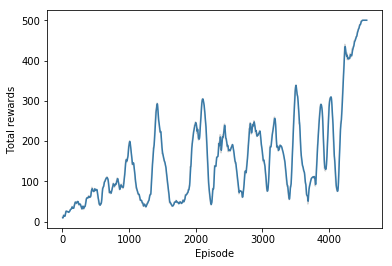

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

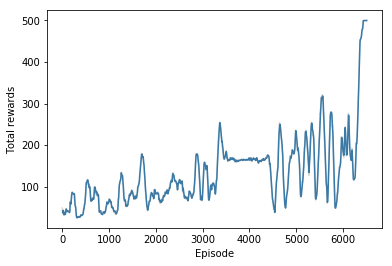

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

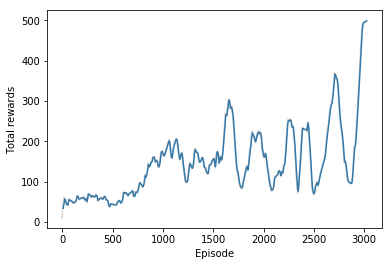

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

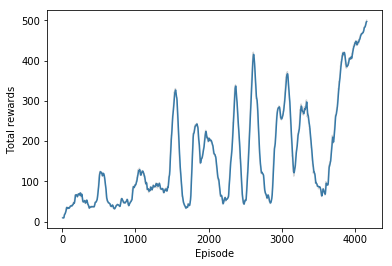

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

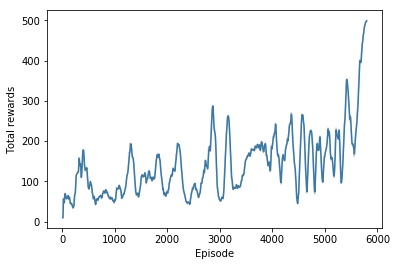

In [184]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

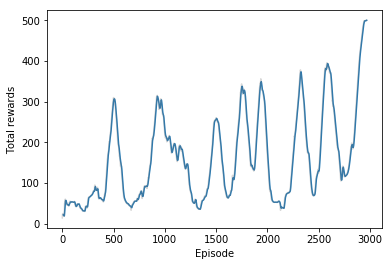

In [178]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

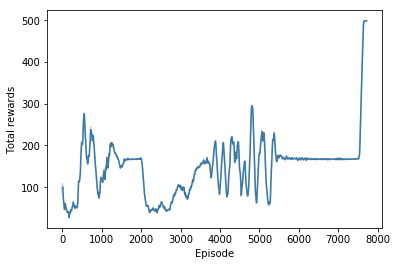

In [173]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

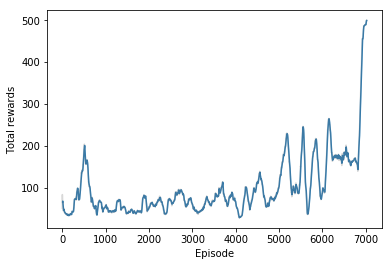

In [166]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

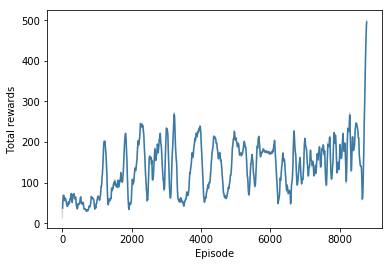

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

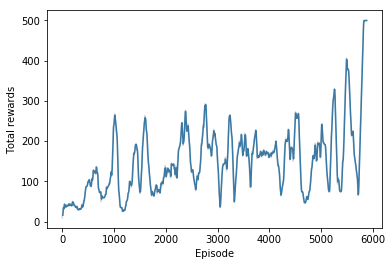

In [157]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

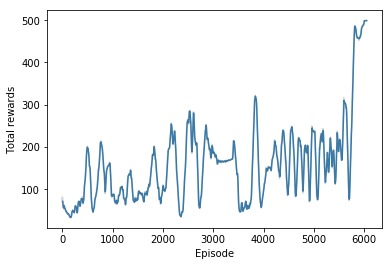

In [154]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

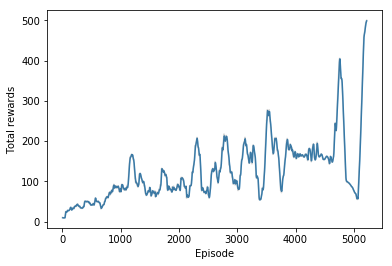

In [82]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

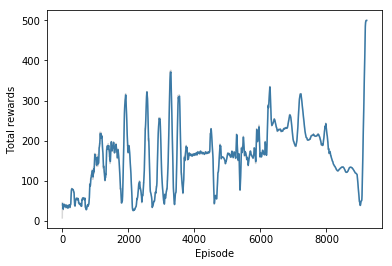

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

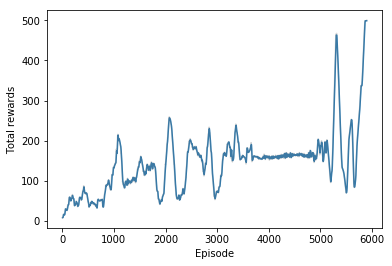

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

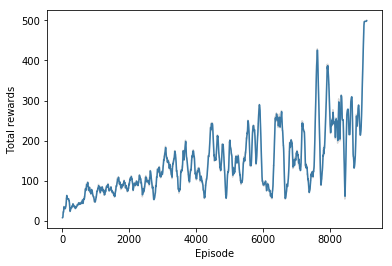

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

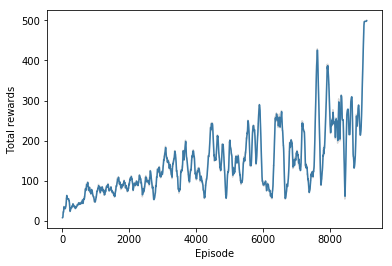

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

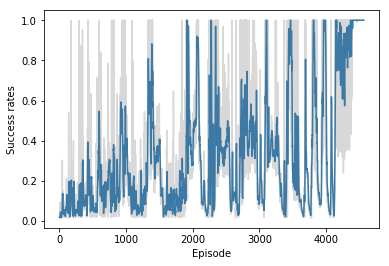

In [38]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'G losses')

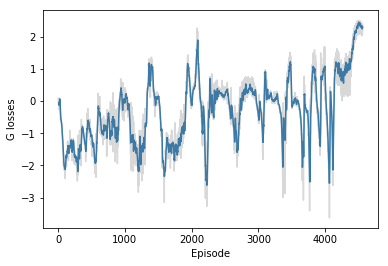

In [40]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

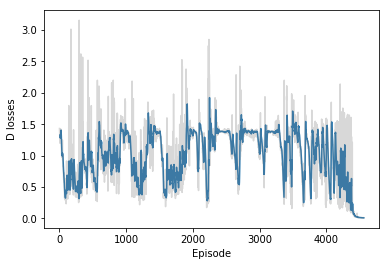

In [41]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

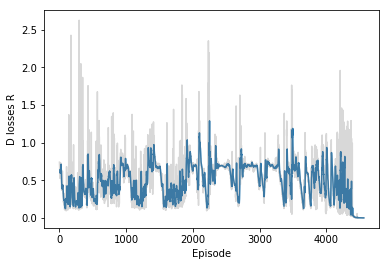

In [42]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

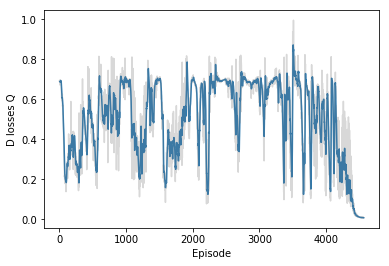

In [43]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.